#### 1. Data Preparation

In [31]:
import pandas as pd

def load_and_describe_csv(file_path: str):
    """
    Loads a CSV file into a pandas dataframe, prints a description of the variables,
    their data types, and the dataframe dimensions.

    Parameters:
    file_path (str): The path to the CSV file to be loaded.

    Returns:
    pd.DataFrame: The dataframe loaded from the CSV file.
    """
    # Load the CSV into a dataframe
    df = pd.read_csv(file_path, encoding="ISO-8859-1")

    # Print the data type of each column
    print("Data types of the columns:")
    print(df.dtypes)
    
    # Print the dimensions of the dataframe
    print("\nDataframe dimensions (rows, columns):")
    print(df.shape)

    # Return the dataframe for further use
    return df

# Load the file and describe its contents
df_macroeconomics = load_and_describe_csv("./data/data_macroeconomics.csv")


Data types of the columns:
Año                                                             int64
Mes                                                            object
PBI (Precios Constantes 2007)                                  object
PBI Per Capita (Precios Constantes 2007)                       object
Total Importaciones (valores FOB millones US$)                  int64
Total Exportaciones (valores FOB millones US$)                  int64
Salida Capital (Activos Sector Público) - millones US$          int64
Entrada de Capital (Pasivos Sector Público) - millones US$      int64
Salidas Capítal (Activos Sector Privado) - millones US$         int64
Entradas Capital (Pasivos sector privado) - millones US$        int64
Tasa de Interes (BCRP)                                        float64
Tipo de Cambio Real Multilateral                              float64
Gastos No financieros del Gobierno Central (millones S/)        int64
Índice de precios Lima Metropolitana (var% mensual) - IPC     f

#### 2. Data Cleaning and Transformation

In [32]:
def clean_and_transform_data(df):
    """
    Cleans and transforms the data by performing the following:
    - Combines 'Año' and 'Mes' into a new datetime column 'año-mes' and places it as the first column.
    - Removes the original 'Año' and 'Mes' columns.
    - Converts 'PBI (Precios Constantes 2007)' and 'PBI Per Capita (Precios Constantes 2007)' to numeric types by removing commas.

    Parameters:
    df (pd.DataFrame): The input dataframe with columns 'Año', 'Mes', 'PBI (Precios Constantes 2007)', and 'PBI Per Capita (Precios Constantes 2007)'.

    Returns:
    pd.DataFrame: The transformed dataframe with the 'año-mes' as the first column.
    """
    # Combine 'Año' and 'Mes' into a single datetime column
    df['año-mes'] = pd.to_datetime(df['Año'].astype(str) + ' ' + df['Mes'], format='%Y %B', errors='coerce')

    # Drop 'Año' and 'Mes' columns
    df.drop(columns=['Año', 'Mes'], inplace=True)

    # Ensure 'año-mes' is the first column
    df = df[['año-mes'] + [col for col in df.columns if col != 'año-mes']]

    # Use .loc to avoid SettingWithCopyWarning and convert columns to numeric by removing commas
    df['PBI (Precios Constantes 2007)'] = pd.to_numeric(df['PBI (Precios Constantes 2007)'].str.replace(',', '').str.strip(), errors='coerce')
    df['PBI Per Capita (Precios Constantes 2007)'] = pd.to_numeric(df['PBI Per Capita (Precios Constantes 2007)'].str.replace(',', '').str.strip(), errors='coerce')

    return df

# Assuming your data is loaded into df
data_me = clean_and_transform_data(df_macroeconomics)

# Print the first few rows of the cleaned dataframe
print(data_me.head())


  año-mes  PBI (Precios Constantes 2007)  \
0     NaT                         486843   
1     NaT                         486843   
2     NaT                         486843   
3     NaT                         486843   
4     NaT                         486843   

   PBI Per Capita (Precios Constantes 2007)  \
0                                     14922   
1                                     14922   
2                                     14922   
3                                     14922   
4                                     14922   

   Total Importaciones (valores FOB millones US$)  \
0                                            2572   
1                                            2317   
2                                            2215   
3                                            2263   
4                                            2728   

   Total Exportaciones (valores FOB millones US$)  \
0                                            2847   
1                          

#### 3. Artifact Building for Principal Component Analysis

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def perform_pca_analysis(df):
    """
    Performs a complete PCA analysis on the provided dataset.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with macroeconomic variables.
    
    Returns:
    dict: Dictionary with all the analysis results.
    """
    # 1. Data preparation
    # Exclude the year-month column from the analysis
    X = df.select_dtypes(include=[np.number])
    
    # 2. Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. Compute the correlation matrix
    correlation_matrix = pd.DataFrame(
        np.corrcoef(X_scaled.T),
        columns=X.columns,
        index=X.columns
    )
    
    # 4. Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # 5. Obtain eigenvalues and explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    eigenvalues = pca.explained_variance_
    
    # 6. Factor loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    # Create visualizations
    def plot_correlation_matrix():
        """Generates and returns a heatmap plot of the correlation matrix."""
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, 
                   annot=True, 
                   cmap='coolwarm', 
                   center=0,
                   fmt='.2f',
                   square=True)
        plt.title('Correlation Matrix')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        return plt.gcf()
    
    def plot_scree():
        """Generates and returns a scree plot showing eigenvalues of components."""
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'ko-', color='black')  # Changed to black
        plt.axhline(y=1, color='r', linestyle='--')
        plt.title('Scree Plot')
        plt.xlabel('Component Number')
        plt.ylabel('Eigenvalue')
        plt.grid(True)
        return plt.gcf()
    
    def plot_explained_variance():
        """Generates and returns a plot of the cumulative explained variance."""
        plt.figure(figsize=(10, 6))
        cumsum = np.cumsum(explained_variance_ratio)
        plt.plot(range(1, len(cumsum) + 1), cumsum, 'ko-', color='black')  # Changed to black
        plt.title('Cumulative Explained Variance')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid(True)
        return plt.gcf()
    
    def plot_loadings_heatmap(n_components=2):
        """Generates and returns a heatmap plot of the factor loadings."""
        plt.figure(figsize=(12, 8))
        loadings_df = pd.DataFrame(
            loadings[:, :n_components],
            columns=[f'PC{i+1}' for i in range(n_components)],
            index=X.columns
        )
        sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
        plt.title('Factor Loadings')
        return plt.gcf()
    
    # Results
    results = {
        'correlation_matrix': correlation_matrix,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': np.cumsum(explained_variance_ratio),
        'eigenvalues': eigenvalues,
        'loadings': pd.DataFrame(
            loadings,
            columns=[f'PC{i+1}' for i in range(loadings.shape[1])],
            index=X.columns
        ),
        'scores': pd.DataFrame(
            X_pca,
            columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
            index=df.index
        ),
        'plots': {
            'correlation_matrix': plot_correlation_matrix(),
            'scree': plot_scree(),
            'explained_variance': plot_explained_variance(),
            'loadings_heatmap': plot_loadings_heatmap()
        }
    }
    
    return results

def interpret_results(results):
    """
    Interprets the PCA results and generates a summary.
    
    Parameters:
    results (dict): Dictionary containing the PCA analysis results.
    
    Returns:
    str: Interpretation summary.
    """
    # Identify components according to Kaiser's criterion
    n_components = sum(results['eigenvalues'] > 1)
    
    # Calculate explained variance for the selected components
    explained_variance = results['cumulative_variance'][n_components-1] * 100
    
    # Analyze strong correlations
    corr_matrix = results['correlation_matrix']
    strong_correlations = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i,j]) > 0.7:  # threshold of 0.7 for strong correlations
                strong_correlations.append(
                    f"{corr_matrix.index[i]} - {corr_matrix.columns[j]}: {corr_matrix.iloc[i,j]:.3f}"
                )
    
    # Identify the most important variables by component
    significant_loadings = results['loadings'].iloc[:, :n_components].abs() > 0.5
    
    interpretation = f"""
    Results of Principal Component Analysis:
    
    1. Number of retained components (Kaiser criterion): {n_components}
    2. Cumulative explained variance: {explained_variance:.2f}%
    
    Strong correlations identified (|r| > 0.7):
    """
    
    for corr in strong_correlations:
        interpretation += f"\n- {corr}"
    
    interpretation += "\n\nInterpretation by component:"
    
    for i in range(n_components):
        significant_vars = results['loadings'].index[significant_loadings.iloc[:, i]]
        interpretation += f"\nComponent {i+1}:"
        interpretation += f"\n- Explained variance: {results['explained_variance_ratio'][i]*100:.2f}%"
        interpretation += f"\n- Significant variables (|loading| > 0.5):"
        for var in significant_vars:
            loading = results['loadings'].iloc[results['loadings'].index == var, i].values[0]
            interpretation += f"\n  * {var}: {loading:.3f}"
    
    return interpretation


#### 4. Results

C:\Users\Lino\AppData\Local\Temp\ipykernel_24548\1655262397.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'ko-', color='black')  # Changed to black
C:\Users\Lino\AppData\Local\Temp\ipykernel_24548\1655262397.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(range(1, len(cumsum) + 1), cumsum, 'ko-', color='black')  # Changed to black
C:\Users\Lino\AppData\Local\Temp\ipykernel_24548\2819838318.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  results['plots']['correlation_matrix'].show()


                                                    PBI (Precios Constantes 2007)  \
PBI (Precios Constantes 2007)                                            1.000000   
PBI Per Capita (Precios Constantes 2007)                                 1.000000   
Total Importaciones (valores FOB millones US$)                           0.771536   
Total Exportaciones (valores FOB millones US$)                           0.590219   
Salida Capital (Activos Sector Público) - millo...                      -0.810305   
Entrada de Capital (Pasivos Sector Público) - m...                       0.008685   
Salidas Capítal (Activos Sector Privado) - mill...                      -0.704938   
Entradas Capital (Pasivos sector privado) - mil...                       0.441609   
Tasa de Interes (BCRP)                                                  -0.209165   
Tipo de Cambio Real Multilateral                                         0.812402   
Gastos No financieros del Gobierno Central (mil...               

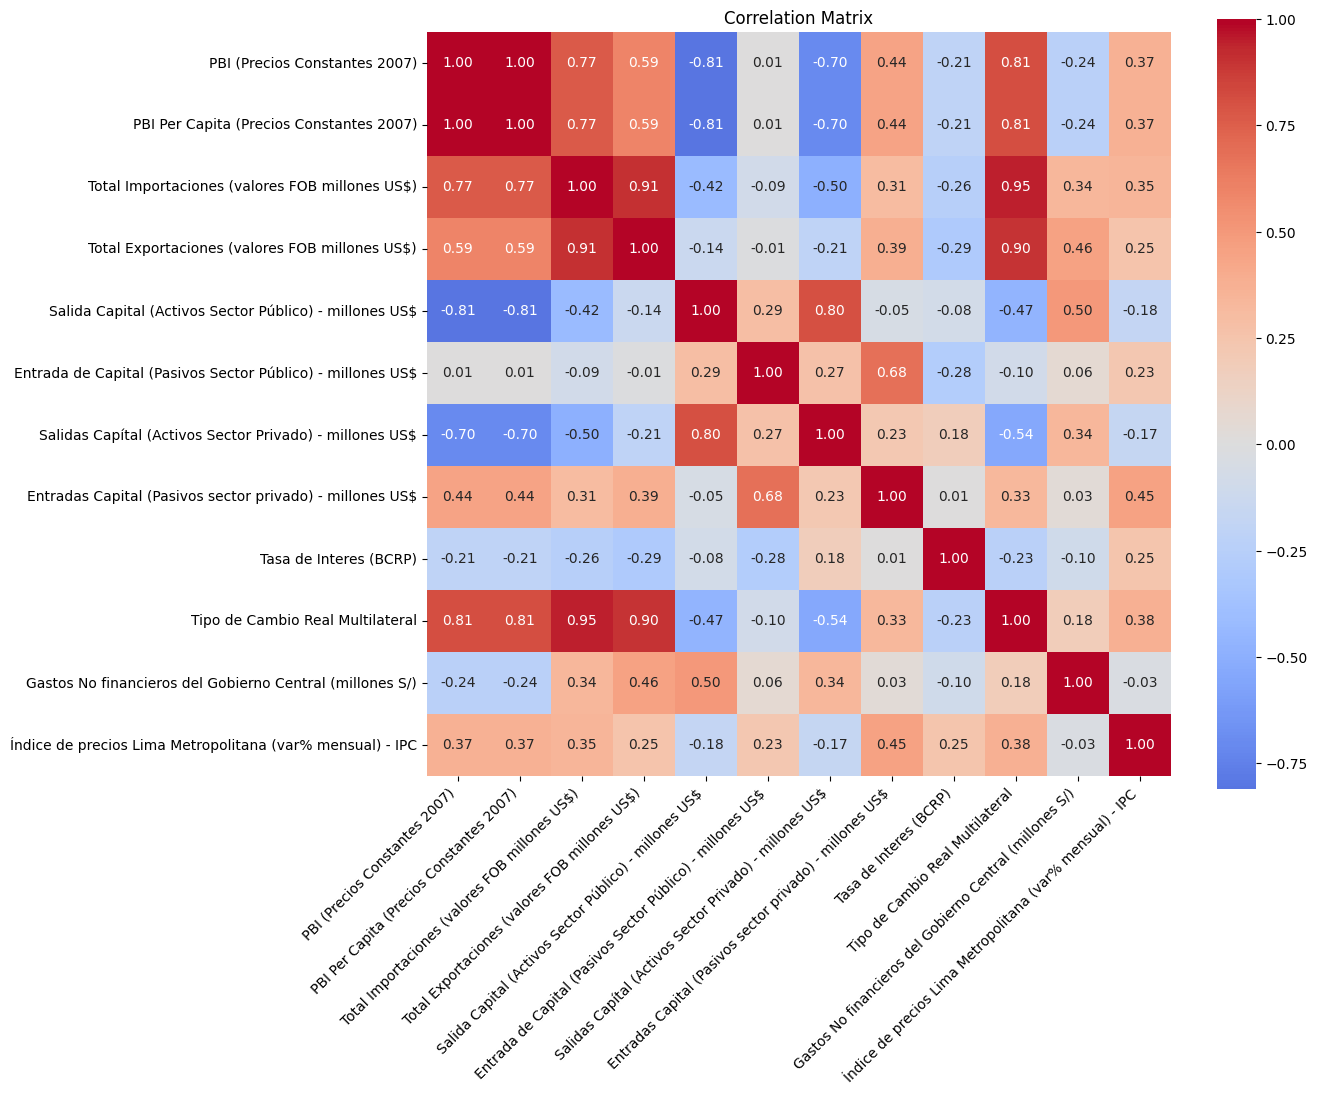

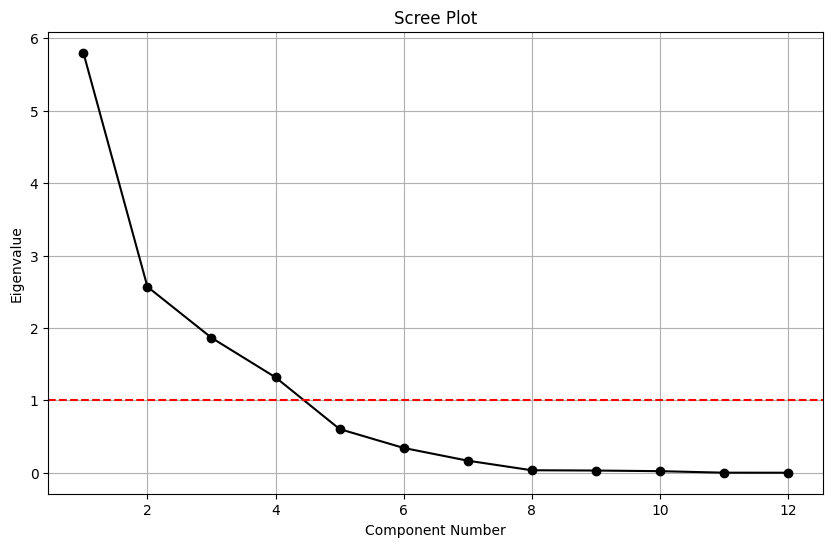

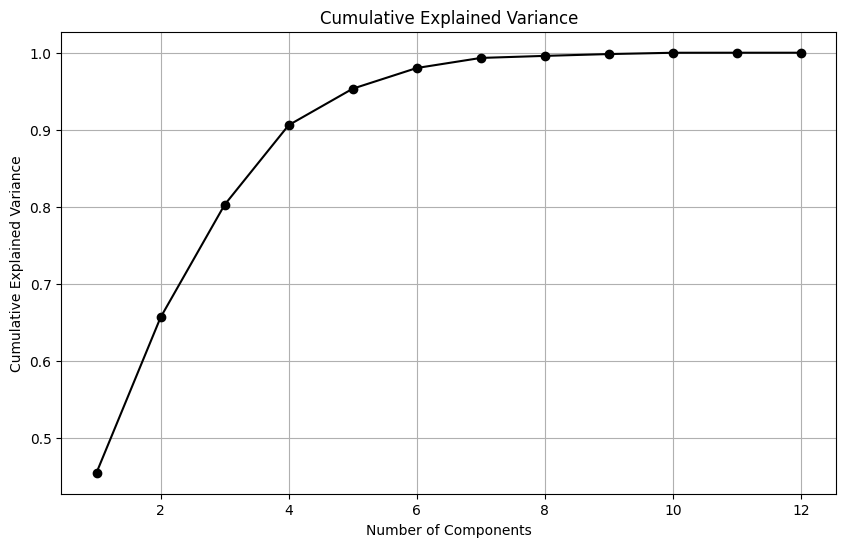

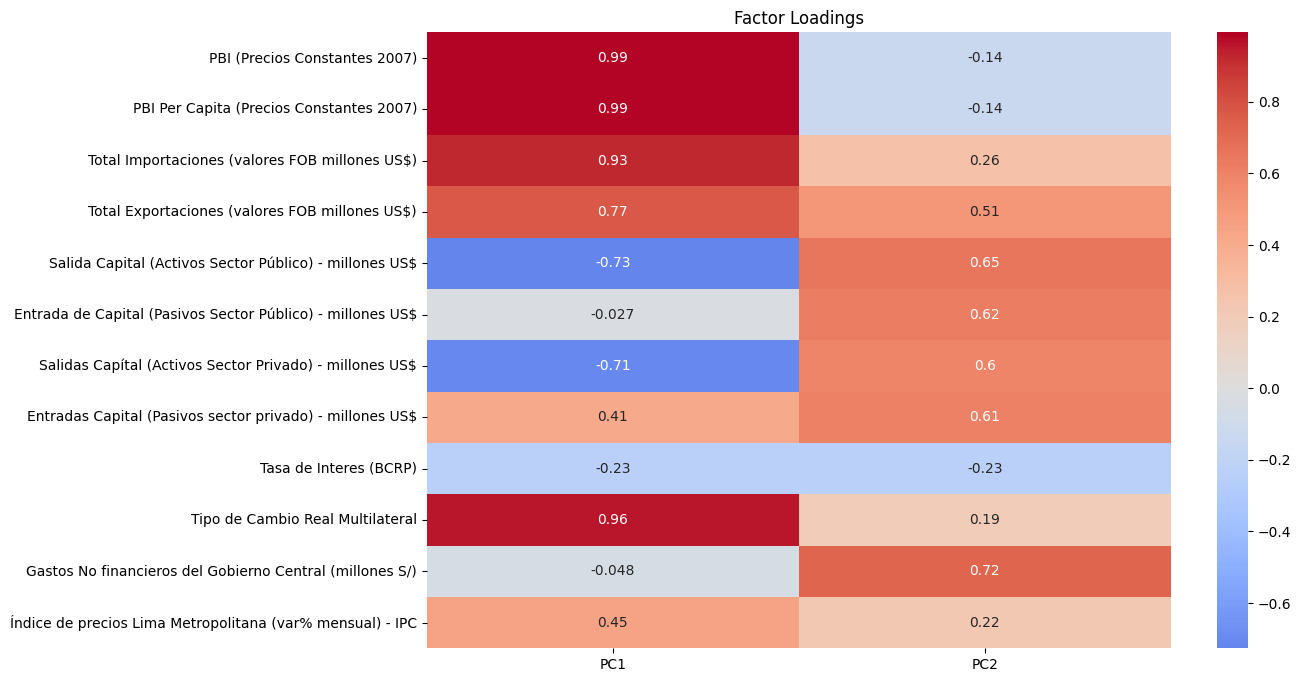

In [38]:
results = perform_pca_analysis(data_me)

# Ver la matriz de correlaciones como DataFrame
print(results['correlation_matrix'])

# Visualizar el mapa de calor de correlaciones
results['plots']['correlation_matrix'].show()

# Ver la interpretación que incluye correlaciones fuertes
print(interpret_results(results))